In [183]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from collections import Counter
import yaml

%matplotlib inline
ox.__version__

'1.7.1'

In [184]:
# set location and radius
lily = (36.00780585133558, -78.91533560763814)  # coords
radius = 500                                    # meters

In [185]:
# download network
dist_type = "network"
network_type = "all"

G = ox.graph_from_point(lily, 
                        dist=radius,
                        network_type=network_type,
                        simplify=False,
                        retain_all=True          # remove later
                        )

In [186]:
# separate into node and edge lists
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

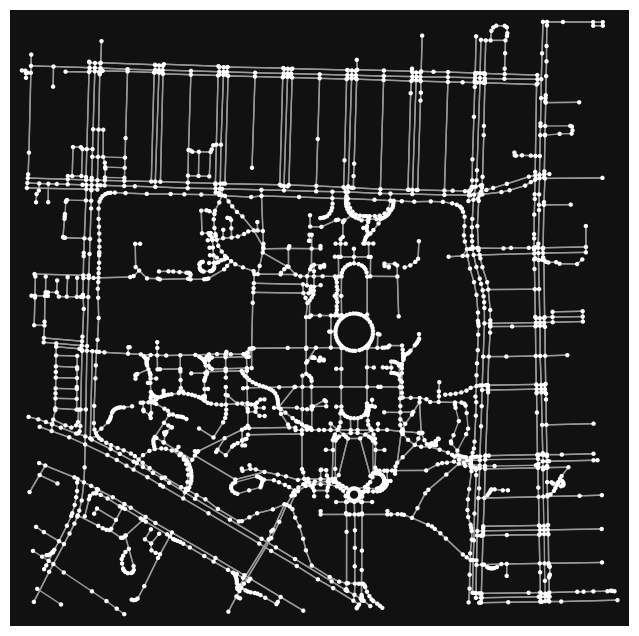

In [187]:
# check 
G_inter = ox.graph_from_gdfs(nodes, edges)
G_inter = ox.project_graph(G_inter)
fig, ax = ox.plot_graph(G_inter, node_size=10)

In [188]:
# Add buildings as nodes to network
# TODO: add amenities
tags = {"building": True}                               # tags = {"building": True, "amentiy": True}
buildings = ox.features_from_point(lily, tags, dist=radius)

centroids = buildings.centroid
building_list = []
edge_list = []
# iterate over buildings
for i, c in enumerate(centroids):
    # create node list
    building_list.append({'geometry': Point(c.x, c.y),
                          'osmid': i+1,
                          'y': c.y,
                          'x': c.x,
                          'building': buildings.iloc[i]['building'],
                          })
    # find closest preexisiting node in G
    proxy_node_id, dist = ox.distance.nearest_nodes(G, c.x, c.y, return_dist=True)
    proxy_node = nodes.loc[proxy_node_id]
    
    # create edge list of building node to proxy node
    edge_list.append({'geometry': LineString([(c.x, c.y), (proxy_node.x, proxy_node.y)]),
                      'osmid': 2000000+i+1,
                      'highway': 'residential',
                      'oneway': False,
                      'length': dist,
                      'lanes': 1,
                      'u': i+1,
                      'v': proxy_node_id,
                      'key': 0,
                      })

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_59411/34084761.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid


In [189]:
# Turn into dfs and set compatible idxs
my_nodes = gpd.GeoDataFrame(building_list)
my_nodes.set_index('osmid', inplace=True)

my_edges = gpd.GeoDataFrame(edge_list)
my_edges.set_index(['u', 'v', 'key'], inplace=True)

# transform street_count to building, drop highway
nodes['building'] = 'street'
nodes = nodes.drop(['street_count', 'highway'], axis=1)

# Combine building and intersection nodes; Combine edges
all_nodes = pd.concat([nodes, my_nodes])
all_edges = pd.concat([edges, my_edges])

# Simplify edges and nodes
all_nodes = all_nodes[['building', 'x', 'y', 'geometry']]
all_edges = all_edges[['osmid', 'highway', 'length', 'geometry']]

# Make graph
G_b = ox.graph_from_gdfs(all_nodes, all_edges)

/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


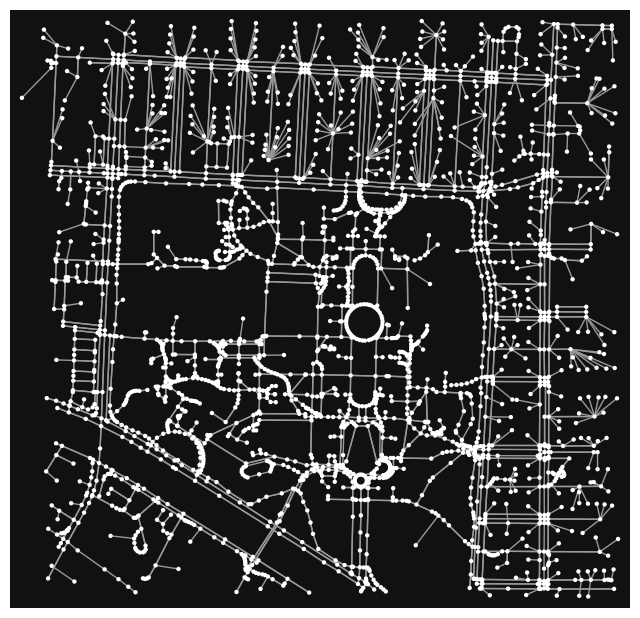

In [190]:
# check network
fig, ax = ox.plot_graph(G_b, node_size=10)

In [191]:
# simplify network
# collapse nodes within tolerance
G_s = ox.project_graph(G_b)
G_s = ox.consolidate_intersections(G_s, rebuild_graph=True, reconnect_edges=True, 
                                 dead_ends=True, tolerance=5)
# remove islands
G_s = ox.utils_graph.get_largest_component(G_s)

/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14-0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.loc[idx, "cluster"] = f"{cluster_label}-{suffix}"


In [192]:
s_nodes, s_edges = ox.graph_to_gdfs(G_s, nodes=True, edges=True)

In [193]:
# set building type according to majority vote
for i, r in s_nodes.iterrows():
    if type(r['osmid_original']) == str:
        osmid_list = [int(i) for i in r['osmid_original'][1:-1].split(", ")]

        counts = {}
        for n in osmid_list:
            build_type = all_nodes.loc[n, 'building']
            if build_type in counts:
                counts[build_type] = counts[build_type] + 1
            else:
                counts[build_type] = 1

        maj_vote = max(counts.items(), key=lambda x: x[1])[0]
        s_nodes.loc[i, 'building'] = maj_vote


In [194]:
# read building and highway OSM saved as yaml
with open('building.yaml', 'r') as f:
    building_yaml = yaml.safe_load(f)

with open('highway.yaml', 'r') as f:
    highway_yaml = yaml.safe_load(f)

In [195]:
# Add node building attributes
for i, r in s_nodes.iterrows():
    building = s_nodes.loc[i, 'building']
    if building in building_yaml.keys():
        general, color = building_yaml[building]['general'], building_yaml[building]['color']
    else:
        general, color = building, 'gray'
    s_nodes.loc[i, 'general'] = general
    s_nodes.loc[i, 'color'] = color

# Add edge street attributes
for i, r in s_edges.iterrows():
    highway = s_edges.loc[i, 'highway']
    if highway in highway_yaml.keys():
        general, color = highway_yaml[highway]['general'], highway_yaml[highway]['color']
    else:
        general, color = highway, 'gray'
    s_edges.loc[i, 'general'] = general
    s_edges.loc[i, 'color'] = color

/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_59411/2459151504.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'street' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  s_nodes.loc[i, 'general'] = general
/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_59411/2459151504.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gray' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  s_nodes.loc[i, 'color'] = color
/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_59411/2459151504.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'car' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  s_edges.loc[i, 'general'] = general
/va

In [196]:
# Simplify edges and nodes
s_nodes = s_nodes[['osmid', 'building', 'general', 'color', 'x', 'y', 'geometry']]
s_edges = s_edges[['osmid', 'highway', 'general', 'color', 'length', 'geometry']]

# Make graph
G_ss = ox.graph_from_gdfs(s_nodes, s_edges)

KeyError: "['osmid'] not in index"

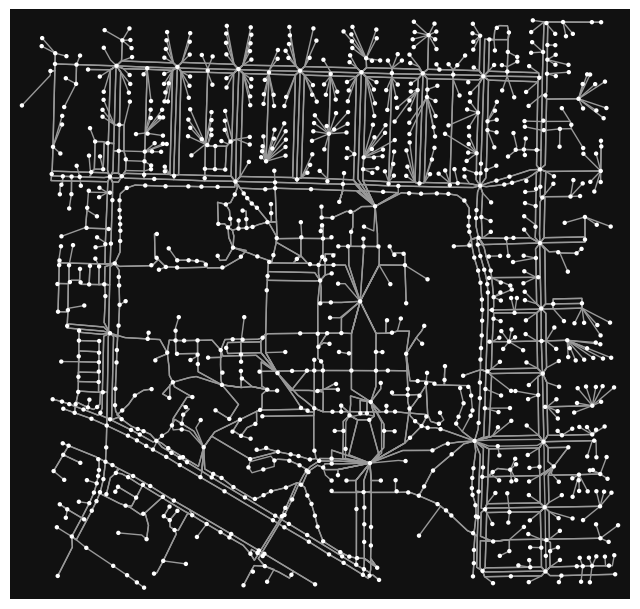

In [ ]:
# check network
fig, ax = ox.plot_graph(G_ss, node_size=10)

In [ ]:
osm_file = "./east_yaml.osm"

In [ ]:
# save graph
ox.save_graphml(G_ss, filepath=osm_file)

In [ ]:
# load save & check
G_star = ox.load_graphml(osm_file,
                         node_dtypes={'building':str, 'general':str, 'color':str, 'x':float, 'y':float, 'geometry':str},
                         edge_dtypes={'osmid':int, 'highway':str, 'general':str, 'color':str, 'length':float, 'geometry':str})

In [ ]:
for k, v in G_star.nodes(data=True):
    print(k, v['x'])

2 688169.4497782105
3 688165.103413244
4 688162.1486630832
6 688257.5972507185
130 688172.3914169612
561 688209.8327336583
117 688172.1820424872
5 688161.2421636934
116 688199.9322183755
125 688160.971502464
51 688260.3137754995
59 688157.7061052432
96 688138.1849373053
431 688117.8288494052
252 688148.8922775086
249 688147.8162352719
58 688258.143276686
128 688252.2257502817
187 688278.9675308949
134 688255.313830797
7 687547.2267242245
8 687534.319538859
9 687516.8009993602
10 687491.9680863633
11 687443.8719143108
12 687417.9321139334
13 687439.9372961769
14 687392.7643217859
16 687391.2398210586
15 687453.6633300564
455 687409.8357674552
456 687449.2094134666
204 687462.0469921282
17 687938.6271270579
18 687950.3871164087
19 687940.4224157336
20 687904.1350085203
21 687964.1455539761
498 687967.4482193348
22 687926.701032516
23 687878.0196962315
451 687940.8946591467
234 687928.0818069184
236 687952.8464096372
499 687901.5050448716
24 687841.9105301461
25 687798.1537543488
26 68777

In [ ]:
# make geographically accurate layout
layout = { n[0] : [ n[1]['x'], n[1]['y'] ] for n in G_star.nodes(data=True) }

# Make Undirected
uG_star = G_star.to_undirected()

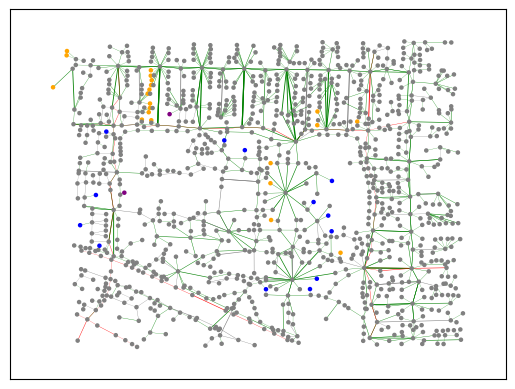

In [ ]:
# draw save
nodes, edges = uG_star.nodes(data=True), uG_star.edges(data=True)

node_color = [ v['color'] for (k, v) in nodes ]
edge_color = [ d['color'] for (u, v, d) in edges ]
max_road_len = max([ d['length'] for (u, v, d) in edges ])
edge_weight = [ d['length'] / max_road_len for (u, v, d) in edges ]

nx.draw_networkx(uG_star, pos=layout,
                 edge_color=edge_color, 
                 node_color=node_color,
                 width=edge_weight,
                 node_size=5,     # edge_cmap
                 with_labels=False)

In [ ]:
for i, n in enumerate(nodes):
    print(i, n)

0 (2, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688169.4497782105, 'y': 3986815.5444872607})
1 (3, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688165.103413244, 'y': 3986758.8582120207})
2 (4, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688162.1486630832, 'y': 3986846.8643766735})
3 (6, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688257.5972507185, 'y': 3986818.2157254093})
4 (130, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688172.3914169612, 'y': 3986838.521129281})
5 (561, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688209.8327336583, 'y': 3986810.377840208})
6 (117, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688172.1820424872, 'y': 3986799.9036880643})
7 (5, {'building': 'street', 'general': 'street', 'color': 'gray', 'x': 688161.2421636934, 'y': 3986705.731861326})
8 (116, {'building': 'street', 'general': 'street', 'color': '

In [ ]:
building_types = Counter()
for n in nodes:
    building_types.update([n[1]['building']])
building_types

Counter({'street': 651,
         'retail': 3,
         'school': 1,
         'university': 9,
         'dormitory': 4,
         'yes': 446,
         'detached': 13,
         'roof': 8,
         'garage': 5,
         'church': 1,
         'shed': 2,
         'house': 3,
         'grandstand': 1,
         'apartments': 1})